# MHC Binding Prediction

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc

import seaborn as sns

import time
from IPython.display import display

%matplotlib inline

Load experimental dataset

`Encode peptides` 
\Carolyn: please investigate previous work on encoding method, including not limited to,
https://dmnfarrell.github.io/bioinformatics/mhclearning
* one-hot
* sliding window (3)
* NLF
* Blosum


`One-hot`

In [2]:
from sklearn.preprocessing import OneHotEncoder

def show_matrix(m):
    cm = sns.light_palette("seagreen", as_cmap=True)
    display(m.style.background_gradient(cmap=cm))

def one_hot_encode(seq):
    o = list(set(codes) - set(seq))
    s = pd.DataFrame(list(seq))    
    x = pd.DataFrame(np.zeros((len(seq),len(o)),dtype=int),columns=o)    
    a = s[0].str.get_dummies(sep=',')
    a = a.join(x)
    a = a.sort_index(axis=1)
    #show_matrix(a)
    e = a.values.flatten()
    return e

pep='ALDFEQEMT'

train_csv = pd.read_csv("dataset/mhc_train.csv")
train_csv['seq_1'], train_csv['seq_2'], train_csv['seq_3'], train_csv['seq_4'],\
    train_csv['seq_5'], train_csv['seq_6'], train_csv['seq_7'], train_csv['seq_8'], train_csv['seq_9']= list(train_csv['sequence'].str)
columns = ['seq_1', 'seq_2', 'seq_3', 'seq_4',
       'seq_5', 'seq_6', 'seq_7', 'seq_8', 'seq_9']
codes = pd.unique(train_csv[columns].values.ravel())
e=one_hot_encode(pep)

<ipython-input-2-15e4430c98f9>:22: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  train_csv['seq_5'], train_csv['seq_6'], train_csv['seq_7'], train_csv['seq_8'], train_csv['seq_9']= list(train_csv['sequence'].str)


In [5]:
def auc_score(true,sc,cutoff=None):
    if cutoff!=None:
        true = (true<=cutoff).astype(int)
        sc = (sc<=cutoff).astype(int)        
    fpr, tpr, thresholds = roc_curve(true, sc, pos_label=1)
    r = auc(fpr, tpr)
    return  r
    
def MHC_MLPRegressor(X, y, encoder, ax):

    reg = MLPRegressor(hidden_layer_sizes=(20), alpha=0.01, max_iter=500,
                        activation='relu', solver='adam', random_state=2)
    X = X.apply(lambda x: pd.Series(encoder(x)),1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    x=pd.DataFrame(np.column_stack([y_test,y_pred]),columns=['test','predicted'])
    x.plot('test','predicted',kind='scatter',s=20,ax=ax)
    ax.plot((0,1), (0,1), ls="--", lw=2, c=".2")
    ax.set_xlim((0,1));  ax.set_ylim((0,1))
    ax.set_title(encoder.__name__)    
    auc = auc_score(y_test,y_pred,cutoff=.426)
    ax.text(.1,.9,'auc=%s' %round(auc,2))
    sns.despine()

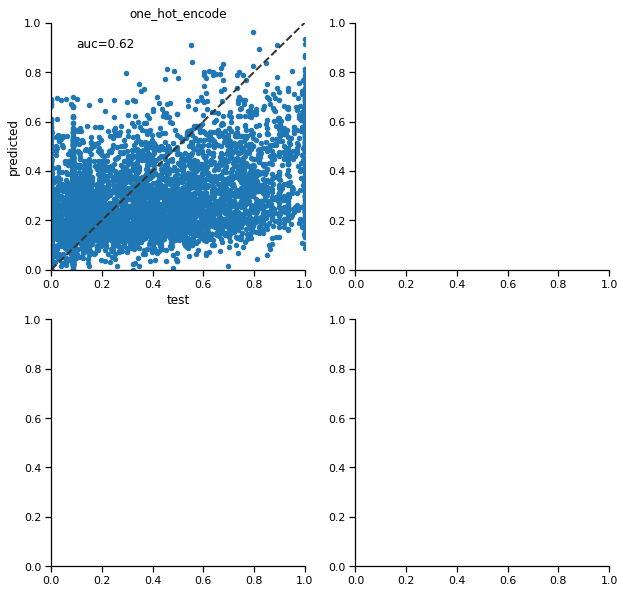

In [6]:
train_csv = pd.read_csv("dataset/mhc_train.csv")

sns.set_context('notebook')
encs=[one_hot_encode]
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs=axs.flat
i=0
for enc in encs:
    MHC_MLPRegressor(train_csv['sequence'],train_csv['meas'], enc,ax=axs[i])
    i+=1